In [1]:
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()
import openl3
import soundfile as sf
import sounddevice as sd
from openl3.core import _preprocess_audio_batch
from kapre.time_frequency import Spectrogram, Melspectrogram
from keras.layers import Input
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
from librosa import display
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14488557840080461567,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 271484359776362700
 physical_device_desc: "device: XLA_CPU device"]

In [3]:
# Read in a single example
audio, sr = sf.read("LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac")
# sr = sample rate = # of samples per second
# audio = data for each sample 
#sd.play(audio, sr)
#status = sd.wait()

In [20]:
# Pre-process with padding, centering, hop size, etc. 
audio_prep = _preprocess_audio_batch(audio, sr, center=False, hop_size=0.1)

In [21]:
print("Original audio: ", audio.shape) # samples (one channel)
print("Preprocessed audio: ", audio_prep.shape) # number of frames x channels x samples per frame
# Note: number of frames x samples per frame > original number of samples in audio because
#      1) frames overlap, and
#      2) preprocessing function upsamples to sr of 48000

Original audio:  (225360,)
Preprocessed audio:  (132, 1, 48000)


In [7]:
# Parameters for mel spectrogram transformation
# From _construct_mel256_audio_network at https://github.com/marl/openl3/blob/master/openl3/models.py
weight_decay = 1e-5
n_dft = 2048
n_mels = 256
n_hop = 242
asr = 48000
audio_window_dur = 1
# Do the mel spectrogram transformation
sess = tf.Session()
with sess.as_default():
    audio_mel = Melspectrogram(n_dft=n_dft, n_hop=n_hop, n_mels=n_mels,
                              sr=asr, power_melgram=1.0, htk=True, # n_win=n_win,
                              return_decibel_melgram=True, padding='same')(tf.keras.backend.variable(audio_prep))

In [8]:
print("Mel spectrogram: ", audio_mel.shape)

Mel spectrogram:  (137, 256, 199, 1)


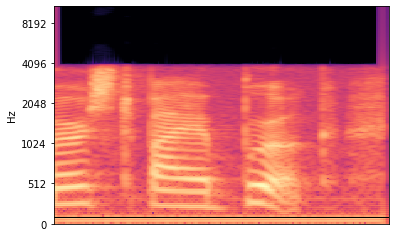

In [19]:
display.specshow(audio_mel[136, :, :, 0].numpy(), y_axis='mel', sr=sr)

In [43]:
# Read in saved spectrogram
path = "/scratch/bs3743/audio_embeddings/LibriSpeech/spectrograms/8113-117384-0007.npy"
print(os.path.getsize(path))
with open(path, 'rb+') as f:
    audio_mel = np.load(f)
audio_mel

14570112


array([[[[-80.       ],
         [-80.       ],
         [-80.       ],
         ...,
         [-22.380451 ],
         [-22.788582 ],
         [-24.320303 ]],

        [[-80.       ],
         [-80.       ],
         [-80.       ],
         ...,
         [-24.238796 ],
         [-23.759157 ],
         [-23.680496 ]],

        [[-80.       ],
         [-80.       ],
         [-80.       ],
         ...,
         [-26.803087 ],
         [-24.793392 ],
         [-23.742044 ]],

        ...,

        [[-80.       ],
         [-80.       ],
         [-80.       ],
         ...,
         [-53.00068  ],
         [-50.652493 ],
         [-49.819504 ]],

        [[-80.       ],
         [-80.       ],
         [-80.       ],
         ...,
         [-53.03651  ],
         [-50.68803  ],
         [-49.855133 ]],

        [[-80.       ],
         [-80.       ],
         [-80.       ],
         ...,
         [-53.058556 ],
         [-50.71027  ],
         [-49.877243 ]]],


       [[[-80.       ],


In [22]:
audio_mel.shape

TensorShape([Dimension(137), Dimension(256), Dimension(199), Dimension(1)])